In [1]:
import bempp.api 
import numpy as np
import time
from login import gmres 
from operators import PMCHWT_operator

bempp.api.set_ipython_notebook_viewer()

In [2]:
from bempp.core.common.global_parameters import global_parameters # Interface to define global_parameters for operators

quad_mu= [1,1,1,1]
quad_nu= [4,3,2,6]
quad_dense= [10,10,10,12]
quad_default = []

mu = 0.1
nu = 0.001

Comment out appropriately. The first is for one cube, the other for 3. And you can also choose different refractive indices.
Choose a large wavelength if you're running it on a personal machine

In [3]:
##for single particle scattering alter the following options
# ref_index = [1.311 + 2.289E-9j]
# # ref_index = [1.0833 + 0.204j]
# centers = [(0,0,0)]

##for multi-particle scattering alter the following options
ref_index = [1.311 + 2.289E-9j, 1.311 + 2.289E-9j,  1.311 + 2.289E-9j] #high absorption
# ref_index = [1.0833 + 0.204j, 1.0833 + 0.204j, 1.0833 + 0.204j] #low absorption 
centers = [(-1,0,0), (0,0,0), (1,0,0)]

# wavelength = 0.55 #corresponds to ref_index=1.311 + 2.289E-9j
wavelength = 3
k_ext = 2*np.pi/wavelength
k_int = [k_ext * i for i in ref_index]
number_of_scatterers = len(k_int)

print("The exterior wavenumber is: {0}".format(k_ext))
print("The interior wavenumbers are: {0}".format(k_int))

mu_int = number_of_scatterers * [1.0]
mu_ext = 1.0
precision = 10 # precision r
h = 2.0 * np.pi / (precision * k_ext)
print('mesh size: {0}'.format(h))


radius = .4
grids = [bempp.api.shapes.cube(length = radius, origin=c, h=h) for c in centers]

The exterior wavenumber is: 2.0943951023931953
The interior wavenumbers are: [(2.745751979237479+4.794070389378024e-09j), (2.745751979237479+4.794070389378024e-09j), (2.745751979237479+4.794070389378024e-09j)]
mesh size: 0.30000000000000004


The next defines an incident plane wave and its dirichlet and neumann traces

In [4]:
# Specify the incident field and its traces

def incident_field(x):
    return np.array([0. * x[2], 0. * x[2], np.exp(1j * k_ext * x[0])])

def dirichlet_trace_fun(x, n, domain_index, result):
    result[:] = np.cross(incident_field(x), n)

def curl(incident_field,x):
    return np.array([0,  - 1j * k_ext * np.exp(1j * k_ext * x[0]), 0])

def neumann_trace_fun(x, n, domain_index, result):
    result[:] = (1/(1j * k_ext)) * np.cross(curl(incident_field,x), n)

The following gets the memory of a weak form operator. I didn't set it up in the smartest way so you need to divide by 2 depending on the discretisation you're using: if only RWG functions are used for the operator and BC for the preconditioner then you take advantage of caching, so operators are assembled only once --> therefore divide by 2. Otherwise, if you're using a mixed discretisation (default in bempp) then no caching, so use the number as it is. The result is in bytes.

In [5]:
def get_memory(number_of_scatterers, operator):
    mem = 0
    
    
    for i in range(2*number_of_scatterers):
        for j in range(2*number_of_scatterers):
            op = operator[i][j]
            mem += op.memory
    return mem
            

The next allows you to change the internal parameters used in bempp. For more info see my paper on Accelerated Calderon preconditioning 

In [6]:
################################################
# Parameters default

parameters_default = global_parameters()
hmat_eps_default =  parameters_default.hmat.eps
quad_default.append(parameters_default.quadrature.near.double_order)
quad_default.append(parameters_default.quadrature.medium.double_order)
quad_default.append(parameters_default.quadrature.far.double_order)
quad_default.append(parameters_default.quadrature.double_singular)

################################################
# Parameters nu

parameters_nu = global_parameters()
if nu == -1:
	parameters_nu.assembly.boundary_operator_assembly_type='dense'
else:
	parameters_nu.assembly.boundary_operator_assembly_type='hmat'
parameters_nu.hmat.eps = nu
parameters_nu.quadrature.double_singular = quad_nu[3]
parameters_nu.quadrature.far.double_order = quad_nu[2]
parameters_nu.quadrature.medium.double_order = quad_nu[1]
parameters_nu.quadrature.near.double_order = quad_nu[0]

################################################
# Parameters mu

parameters_mu = global_parameters()
if mu == -1:
	parameters_mu.assembly.boundary_operator_assembly_type='dense'
else:
	parameters_mu.assembly.boundary_operator_assembly_type='hmat'
parameters_mu.hmat.eps = mu
parameters_mu.quadrature.double_singular = quad_mu[3]
parameters_mu.quadrature.far.double_order = quad_mu[2]
parameters_mu.quadrature.medium.double_order = quad_mu[1]
parameters_mu.quadrature.near.double_order = quad_mu[0]

################################################
# Parameters mu1 near field

parameters_mu_nf1 = global_parameters()
if mu == -1:
	parameters_mu_nf1.assembly.boundary_operator_assembly_type='dense'
else:
	parameters_mu_nf1.assembly.boundary_operator_assembly_type='hmat'
parameters_mu_nf1.hmat.eps = mu
parameters_mu_nf1.quadrature.double_singular = quad_mu[3]
parameters_mu_nf1.quadrature.far.double_order = quad_mu[2]
parameters_mu_nf1.quadrature.medium.double_order = quad_mu[1]
parameters_mu_nf1.quadrature.near.double_order = quad_mu[0]
parameters_mu_nf1.hmat.cutoff = 0

################################################

# Parameters dense
parameters_dense = global_parameters()
parameters_dense.assembly.boundary_operator_assembly_type='dense'
parameters_dense.hmat.eps = -1
parameters_dense.quadrature.double_singular = quad_dense[3]
parameters_dense.quadrature.far.double_order = quad_dense[2]
parameters_dense.quadrature.medium.double_order = quad_dense[1]
parameters_dense.quadrature.near.double_order = quad_dense[0]

In [7]:
# # spaces
bc_space = [bempp.api.function_space(grid, "BC", 0) for grid in grids]
rbc_space = [bempp.api.function_space(grid, "RBC", 0) for grid in grids]
rwg_space = [bempp.api.function_space(grid, "RWG", 0) for grid in grids]
snc_space = [bempp.api.function_space(grid, "SNC", 0) for grid in grids]

b_rwg_space = [bempp.api.function_space(grid, "B-RWG", 0) for grid in grids]
b_snc_space = [bempp.api.function_space(grid, "B-SNC", 0) for grid in grids]

N = sum([space.global_dof_count for space in rwg_space])
print (N ,'NDOF')

N_bc = sum([space.global_dof_count for space in bc_space])
print(N_bc, 'NDOF')

378 NDOF
378 NDOF


/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


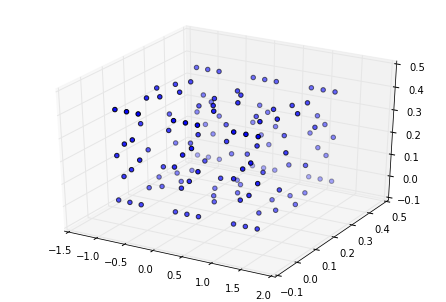

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

for i in range(number_of_scatterers):
    grid = grids[i]
    vertices = grid.leaf_view.vertices
    ax.scatter(vertices[0], vertices[1], vertices[2])

In [9]:
sum_elements = 0

for i in range(number_of_scatterers):
    el = grids[0].leaf_view.elements
    sum_elements += el.shape[1]
print(sum_elements)

252


In [10]:
# set up operators
[PMCHWT_nu, filter_operators_nu] = PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, parameters = parameters_nu)
[_,PMCHWT_diag_nu] = PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, parameters = parameters_nu, 
                                    preconditioner = True)
[_,PMCHWT_diag_mu]= PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, preconditioner = True, 
                                    parameters = parameters_mu)
[_,PMCHWT_diag_mu_nf1]= PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, preconditioner = True, 
                                       parameters = parameters_mu_nf1)


In [11]:
print('creating mass-matrices')
# BC discretisation
mass_matrix_BC_SNC = np.empty((2 * number_of_scatterers, 2 * number_of_scatterers), dtype='O')
t0 = time.time()
for i in range(number_of_scatterers):
    for j in range(number_of_scatterers):
        if i==j:
            id_BC_SNC = bempp.api.operators.boundary.sparse.identity(bc_space[i], bc_space[i], b_snc_space[i])
            inv_identity_BC_SNC = bempp.api.assembly.InverseSparseDiscreteBoundaryOperator(id_BC_SNC.weak_form())
            mass_matrix_BC_SNC[2*i, 2*j] = inv_identity_BC_SNC
            mass_matrix_BC_SNC[2*i + 1, 2*j + 1] = inv_identity_BC_SNC
mass_matrix_BC_SNC = bempp.api.assembly.BlockedDiscreteOperator(mass_matrix_BC_SNC)
ta_mass_matrix_BC_SNC = time.time() - t0
print('assembly time for mass_matrix_BC_SNC: {0}'.format(ta_mass_matrix_BC_SNC))

mass_matrix_BRWG_RBC = np.empty((2*number_of_scatterers, 2*number_of_scatterers), dtype = 'O')
t0 = time.time()
for i in range(number_of_scatterers):
    for j in range(number_of_scatterers):
        if i==j:
            id_BRWG_RBC = bempp.api.operators.boundary.sparse.identity(b_rwg_space[i], b_rwg_space[i], rbc_space[i])
            inv_identity_BRWG_RBC = bempp.api.assembly.InverseSparseDiscreteBoundaryOperator(id_BRWG_RBC.weak_form())
            mass_matrix_BRWG_RBC[2*i, 2*j] = inv_identity_BRWG_RBC
            mass_matrix_BRWG_RBC[2*i + 1, 2*j+1] = inv_identity_BRWG_RBC
mass_matrix_BRWG_RBC = bempp.api.assembly.BlockedDiscreteOperator(mass_matrix_BRWG_RBC)
ta_mass_matrix_BRWG_RBC = time.time() - t0
print('assembly time for mass_matrix_bc: {0}'.format(ta_mass_matrix_BRWG_RBC))

creating mass-matrices
assembly time for mass_matrix_BC_SNC: 0.054167985916137695
assembly time for mass_matrix_bc: 0.015032768249511719


In [12]:
print('assembly of PMCHWT operator - rwg discretisation - parameters_nu')

t0 = time.time()
PMCHWT_nu_wf = PMCHWT_nu.weak_form()
ta_PMCHWT_nu_wf = time.time()- t0
print('assembly time of op_nu_wf: {0}'.format(ta_PMCHWT_nu_wf))

t0 = time.time()
PMCHWT_nu_sf = mass_matrix_BC_SNC * PMCHWT_nu_wf
ta_PMCHWT_nu_sf = time.time() - t0 + ta_PMCHWT_nu_wf + ta_mass_matrix_BC_SNC
print('assembly time of op_none_sf: {0}'.format(ta_PMCHWT_nu_sf))

assembly of PMCHWT operator - rwg discretisation - parameters_nu
assembly time of op_nu_wf: 3.2594809532165527
assembly time of op_none_sf: 3.3138444423675537


In [13]:
print('assembly of PMCHWT diag preconditioner - parameters_nu')
t0 = time.time()
PMCHWT_diag_nu_wf = PMCHWT_diag_nu.weak_form()
ta_PMCHWT_diag_nu_wf = time.time() - t0

assembly of PMCHWT diag preconditioner - parameters_nu


In [14]:
print('assembly of Cald_nu prec')

t0 = time.time()
op_cald_nu_wf = PMCHWT_diag_nu_wf * mass_matrix_BC_SNC * PMCHWT_nu_wf
ta_cald_nu_wf = time.time() - t0 + ta_mass_matrix_BC_SNC + ta_PMCHWT_diag_nu_wf + ta_PMCHWT_nu_wf 

t0 = time.time()
op_cald_nu_sf = mass_matrix_BRWG_RBC * op_cald_nu_wf
ta_cald_nu_sf = time.time() - t0 + ta_cald_nu_wf + ta_mass_matrix_BRWG_RBC

print('time_wf: {0}'.format(ta_cald_nu_wf))
print('time_sf: {0}'.format(ta_cald_nu_sf))



assembly of Cald_nu prec
time_wf: 74.66456961631775
time_sf: 74.67991352081299


In [15]:
print('assembly of bi-Cald prec ')
t0 = time.time()
PMCHWT_diag_mu_wf = PMCHWT_diag_mu.weak_form()
ta_PMCHWT_diag_mu_wf = time.time()-t0

t0 = time.time()
op_cald_bi_wf = PMCHWT_diag_mu_wf * mass_matrix_BC_SNC * PMCHWT_nu_wf
ta_cald_bi_wf = time.time() - t0 + ta_PMCHWT_nu_wf + ta_mass_matrix_BC_SNC + ta_PMCHWT_diag_mu_wf

t0 = time.time()
op_cald_bi_sf = mass_matrix_BRWG_RBC * op_cald_bi_wf
ta_cald_bi_sf = time.time() - t0 + ta_cald_bi_wf + ta_mass_matrix_BRWG_RBC

print('time_wf: {0}'.format(ta_cald_bi_wf))
print('time_sf: {0}'.format(ta_cald_bi_sf))

assembly of bi-Cald prec 
time_wf: 13.48150110244751
time_sf: 13.496683835983276


In [16]:
print('assembly of bi-Cald prec near field1')
t0 = time.time()
PMCHWT_diag_mu_nf1_wf = PMCHWT_diag_mu_nf1.weak_form()
ta_PMCHWT_diag_mu_nf1_wf = time.time()-t0

t0 = time.time()
op_cald_bi_nf1_wf = PMCHWT_diag_mu_nf1_wf * mass_matrix_BC_SNC * PMCHWT_nu_wf
ta_cald_bi_nf1_wf = time.time() - t0 + ta_PMCHWT_nu_wf + ta_mass_matrix_BC_SNC + ta_PMCHWT_diag_mu_nf1_wf

t0 = time.time()
op_cald_bi_nf1_sf = mass_matrix_BRWG_RBC * op_cald_bi_nf1_wf
ta_cald_bi_nf1_sf = time.time() - t0 + ta_cald_bi_nf1_wf + ta_mass_matrix_BRWG_RBC

print('time_wf: {0}'.format(ta_cald_bi_nf1_wf))
print('time_sf: {0}'.format(ta_cald_bi_nf1_sf))

assembly of bi-Cald prec near field1
time_wf: 10.991671085357666
time_sf: 11.006855726242065


In [17]:
## Discretize the incident field
print('defining incident field - RWG')
incident_field_RWG = number_of_scatterers * [None]
for i in range(number_of_scatterers):
    dirichlet_trace_RWG = bempp.api.GridFunction(rwg_space[i], fun=dirichlet_trace_fun)
    neumann_trace_RWG = (k_ext/mu_ext) * bempp.api.GridFunction(rwg_space[i], fun = neumann_trace_fun)
    incident_field_RWG[i] = dirichlet_trace_RWG.coefficients.tolist() +  neumann_trace_RWG.coefficients.tolist()
    

defining incident field - RWG


In [18]:
# Assembly of RHS operators

print('rhs_nu wf & sf')
rhs_nu_wf = []#number_of_scatterers * [None]
for i in range(number_of_scatterers):
    rhs_nu_wf.append(filter_operators_nu[i].weak_form() * incident_field_RWG[i])
rhs_nu_sf = mass_matrix_BC_SNC * [y for x in rhs_nu_wf for y in x]
rhs_nu_wf = [y for x in rhs_nu_wf for y in x]

print('rhs_cald_nu wf & sf')
rhs_cald_nu_wf = PMCHWT_diag_nu_wf * mass_matrix_BC_SNC *rhs_nu_wf
rhs_cald_nu_sf = mass_matrix_BRWG_RBC * rhs_cald_nu_wf

print('rhs_cald_bi wf & sf')
rhs_cald_bi_wf = PMCHWT_diag_mu_wf * mass_matrix_BC_SNC * rhs_nu_wf
rhs_cald_bi_sf = mass_matrix_BRWG_RBC * rhs_cald_bi_wf

print('rhs_cald_bi_nf1 wf & sf')
rhs_cald_bi_nf1_wf = PMCHWT_diag_mu_nf1_wf * mass_matrix_BC_SNC * rhs_nu_wf
rhs_cald_bi_nf1_sf = mass_matrix_BRWG_RBC * rhs_cald_bi_nf1_wf



rhs_nu wf & sf
rhs_cald_nu wf & sf
rhs_cald_bi wf & sf
rhs_cald_bi_nf1 wf & sf


In [19]:
#### solving the linear system
tolerance = 1e-5
restart = 200
maxiter = 2000

print('solve of PMCHWT_nu sf')
bempp.api.MATVEC_COUNT = 0
t0 = time.time()
c_PMCHWT_nu_sf,  info_PMCHWT_nu_sf, res_PMCHWT_nu_sf  = gmres(PMCHWT_nu_sf, rhs_nu_sf, tol=tolerance, restart=restart,
                                                              return_residuals=True, maxiter=maxiter)
ts_PMCHWT_nu_sf = time.time()-t0
matvec_PMCHWT_nu_sf = bempp.api.MATVEC_COUNT
print('number of iterations: {0}'.format(len(res_PMCHWT_nu_sf)))
print(matvec_PMCHWT_nu_sf)

######################################################################################################
print('solver of Calderon_nu sf')
bempp.api.MATVEC_COUNT = 0
t0 = time.time()
c_cald_nu_sf,  info_cald_nu_sf, res_cald_nu_sf  = gmres(op_cald_nu_sf, rhs_cald_nu_sf, tol=tolerance, restart=restart, 
                                            return_residuals=True, maxiter=maxiter)
ts_cald_nu_sf = time.time()-t0
matvec_cald_nu_sf = bempp.api.MATVEC_COUNT 
print('number of iterations: {0}'.format(len(res_cald_nu_sf)))
print(matvec_cald_nu_sf)
# ######################################################################################################
print('solver of bi-Calderon sf')
bempp.api.MATVEC_COUNT = 0
t0 = time.time()
c_bi_sf,  info_bi_sf, res_bi_sf  = gmres(op_cald_bi_sf, rhs_cald_bi_sf, tol=tolerance, restart=restart, 
                                         return_residuals=True, maxiter=maxiter)
ts_bi_sf = time.time()-t0
matvec_bi_sf = bempp.api.MATVEC_COUNT 
print('number of iterations: {0}'.format(len(res_bi_sf)))
print(matvec_bi_sf)
######################################################################################################
print('solver of bi-Calderon near field1 sf')
bempp.api.MATVEC_COUNT = 0
t0 = time.time()
c_bi_nf1_sf,  info_bi_nf1_sf, res_bi_nf1_sf  = gmres(op_cald_bi_nf1_sf, rhs_cald_bi_nf1_sf, tol=tolerance, restart=restart, 
                                            return_residuals=True, maxiter=maxiter)
ts_bi_nf1_sf = time.time()-t0
matvec_bi_nf1_sf = bempp.api.MATVEC_COUNT 
print('number of iterations: {0}'.format(len(res_bi_nf1_sf)))
print(matvec_bi_nf1_sf)

solve of PMCHWT_nu sf
number of iterations: 844
0
solver of Calderon_nu sf
number of iterations: 6
0
solver of bi-Calderon sf
number of iterations: 7
0
solver of bi-Calderon near field1 sf
number of iterations: 7
0


In [20]:
memory_diag_nu = get_memory(number_of_scatterers, PMCHWT_diag_nu_wf)
memory_diag_mu1 = get_memory(number_of_scatterers, PMCHWT_diag_mu_wf)
memory_diag_mu_nf1 = get_memory(number_of_scatterers, PMCHWT_diag_mu_nf1_wf)

In [21]:
table = [
    [np.nan, np.nan, np.nan, nu, quad_nu, len(res_PMCHWT_nu_sf), np.nan, ta_PMCHWT_nu_sf,  ts_PMCHWT_nu_sf, ta_PMCHWT_nu_sf + ts_PMCHWT_nu_sf], 
    [np.nan, np.nan, np.nan, nu, quad_nu, len(res_cald_nu_sf), memory_diag_nu, ta_cald_nu_sf, ts_cald_nu_sf, (ta_cald_nu_sf+ts_cald_nu_sf)], #cald_nu_sf    
    [np.nan, parameters_mu.hmat.eps, quad_mu, nu, quad_nu, len(res_bi_sf), memory_diag_mu1, ta_cald_bi_sf, ts_bi_sf, (ta_cald_bi_sf+ts_bi_sf)], #Bi_sf
    [parameters_mu_nf1.hmat.cutoff, parameters_mu_nf1.hmat.eps , quad_mu, nu, quad_nu, len(res_bi_nf1_sf), memory_diag_mu_nf1, ta_cald_bi_nf1_sf, ts_bi_nf1_sf, (ta_cald_bi_nf1_sf+ts_bi_nf1_sf)] #bi_nf_sf
    ]

In [22]:
lines = list(['$(\mathbf{A})_\nu$  -  sf',
              '$(\mathbf{DA})_\nu$  -  sf', 
              '$(\mathbf{DA})_{\mu,\nu}$  -  sf', 
              '$(\mathbf{DA})_{\mu,\nu}^{nf}$-sf'])
columns = list(['$nf$','$\mu$','$\mathbf{q}_\mu$','$v$','$\mathbf{q}_v$','$n_{iter}$', 'mem$(\mathbf{P})$',
                '$t_{assembly}$','$t_{solver}$', '$t_{total}$'])

In [23]:
import pandas as pd
pd.set_option('display.precision',10)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 15)

result = pd.DataFrame(table,index = lines,columns = columns)

result = result.replace(np.nan,"-")


result

,$nf$,$\mu$,$\mathbf{q}_\mu$,$v$,$\mathbf{q}_v$,$n_{iter}$,mem$(\mathbf{P})$,$t_{assembly}$,$t_{solver}$,$t_{total}$
$(\mathbf{A})_\nu$ - sf,-,-,-,0.001,"[4, 3, 2, 6]",844,-,3.3138444424,11.2720625401,14.5859069824
$(\mathbf{DA})_\nu$ - sf,-,-,-,0.001,"[4, 3, 2, 6]",6,222510.3125,74.6799135208,0.9344356060,75.6143491268
"$(\mathbf{DA})_{\mu,\nu}$ - sf",-,0.1,"[1, 1, 1, 1]",0.001,"[4, 3, 2, 6]",7,126432.3125,13.4966838360,0.9301455021,14.4268293381
"$(\mathbf{DA})_{\mu,\nu}^{nf}$-sf",0,0.1,"[1, 1, 1, 1]",0.001,"[4, 3, 2, 6]",7,126432.3125,11.0068557262,0.9090249538,11.9158806801
